In [1]:
# Load PEP8 checker.
%load_ext pycodestyle_magic
%pycodestyle_on

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from scikeras.wrappers import KerasClassifier
from tensorflow.keras import layers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score

2022-10-21 13:15:53.513496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 13:15:53.513512: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load data from csv file
df = pd.read_csv('iris.csv')

In [25]:
# We take a peek at the data
df.head(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [4]:
%pycodestyle_off

### Change columns names:

In [5]:
df.rename(columns = {'sepal length in cm':'SepalLengthCm', 'sepal width in cm':'SepalWidthCm',
                    'petal length in cm':'PetalLengthCm', 'petal width in cm':'PetalWidthCm',
                    'class':'Species'}, inplace=True)

### Encode labels:

In [6]:
# We use OneHotEncoder, to encode our label.
oh_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cols = oh_encoder.fit_transform(df[['Species']])
feature_labels = oh_encoder.categories_
feature_labels = np.concatenate(feature_labels)
df_encoded = pd.DataFrame(encoded_cols, columns = feature_labels)

# Concatenate encoded labels to the dataframe
df_final = pd.concat([df, df_encoded], axis = 1)

In [7]:
df_final.head(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Iris-setosa,Iris-versicolor,Iris-virginica
0,5.1,3.5,1.4,0.2,Iris-setosa,1.0,0.0,0.0
1,4.9,3.0,1.4,0.2,Iris-setosa,1.0,0.0,0.0
2,4.7,3.2,1.3,0.2,Iris-setosa,1.0,0.0,0.0
3,4.6,3.1,1.5,0.2,Iris-setosa,1.0,0.0,0.0
4,5.0,3.6,1.4,0.2,Iris-setosa,1.0,0.0,0.0
5,5.4,3.9,1.7,0.4,Iris-setosa,1.0,0.0,0.0
6,4.6,3.4,1.4,0.3,Iris-setosa,1.0,0.0,0.0
7,5.0,3.4,1.5,0.2,Iris-setosa,1.0,0.0,0.0
8,4.4,2.9,1.4,0.2,Iris-setosa,1.0,0.0,0.0
9,4.9,3.1,1.5,0.1,Iris-setosa,1.0,0.0,0.0


In [8]:
%pycodestyle_on

In [9]:
def create_compile_fit_model(my_lr, my_feature, my_label,
                             batch_size, epochs, my_validation_split):
    '''
    We create, compile and fit our model

    my_lr (Float): Learning rate selected
    my_feature (DataFrame): feature data to train our model
    my_label (DataFrame): labels to train our moder
    batch_size (int): Quantity of data seen by the model in training
    epochs (int): times the model is going to see the data
    my_validation_split (Float): percentage of data used in validation
    '''

    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    '''
    units = 3, because there are 3 types of labels.
    input_shapes = (4, ), only 4 features
    activation = softmax, return the probability of every label
    kernel_regularizer = l1, apply L1 regularization
    '''

    model.add(tf.keras.layers.Dense(units=3, input_shape=(4, ),
                                    activation='softmax'))

    '''
     Call the compile method to construct the layers into a model that
     TensorFlow can execute.  Notice that we're using a different loss
     function for classification than for regression an a different
     metric as well. We use CATEGORICAL because we have a multiclass
     problem.
    '''
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_lr),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

    History = model.fit(x=my_feature,
                        y=my_label,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=my_validation_split)

    return (History, model)

### Define Features and Labels:

In [10]:
features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

### Split the data into train and test:

In [11]:
X = df_final[features]
y = df_final[labels]

# Our train data is 80% of the total data
# 20% of the data is for training
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)

In [12]:
# Hyperparameters:
learning_rate = 0.04
epochs = 300
batch_size = 128

# Percentage of train data used to validate.
validation_split = 0.2

# Identify the feature and the label.
my_feature = X_train  # Sepal, petal width and length
my_label = y_train  # Encoded species type.

'''
  We're going to create a model that predicts
  flower specie based on sepal and petal carateritics.
'''
# Invoke the functions to build and train the model.
history, model = create_compile_fit_model(learning_rate, my_feature,
                                          my_label, batch_size,
                                          epochs, validation_split)

Epoch 1/300


2022-10-21 13:15:55.618831: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-21 13:15:55.618861: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-21 13:15:55.618879: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (esequiel-B550I-AORUS-PRO-AX): /proc/driver/nvidia/version does not exist
2022-10-21 13:15:55.619134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 235ms/step - loss: 2.2801 - categorical_accuracy: 0.2708 - val_loss: 1.5474 - val_categorical_accuracy: 0.3333
Epoch 2/300
1/1 [==============================] - 0s 11ms/step - loss: 1.8448 - categorical_accuracy: 0.1771 - val_loss: 1.4395 - val_categorical_accuracy: 0.0833
Epoch 3/300
1/1 [==============================] - 0s 12ms/step - loss: 1.5671 - categorical_accuracy: 0.0417 - val_loss: 1.5126 - val_categorical_accuracy: 0.2917
Epoch 4/300
1/1 [==============================] - 0s 10ms/step - loss: 1.4947 - categorical_accuracy: 0.3854 - val_loss: 1.6457 - val_categorical_accuracy: 0.2917
Epoch 5/300
1/1 [==============================] - 0s 9ms/step - loss: 1.5219 - categorical_accuracy: 0.3854 - val_loss: 1.6928 - val_categorical_accuracy: 0.2917
Epoch 6/300
1/1 [==============================] - 0s 10ms/step - loss: 1.5076 - categorical_accuracy: 0.3854 - val_loss: 1.6394 - val_categorical_accuracy: 0.2917
Epoch 7/300
1/1 [===========

Epoch 51/300
1/1 [==============================] - 0s 9ms/step - loss: 0.4002 - categorical_accuracy: 0.8542 - val_loss: 0.4959 - val_categorical_accuracy: 0.7500
Epoch 52/300
1/1 [==============================] - 0s 10ms/step - loss: 0.3973 - categorical_accuracy: 0.8542 - val_loss: 0.4886 - val_categorical_accuracy: 0.7917
Epoch 53/300
1/1 [==============================] - 0s 9ms/step - loss: 0.3940 - categorical_accuracy: 0.8542 - val_loss: 0.4785 - val_categorical_accuracy: 0.7917
Epoch 54/300
1/1 [==============================] - 0s 9ms/step - loss: 0.3906 - categorical_accuracy: 0.8542 - val_loss: 0.4674 - val_categorical_accuracy: 0.7917
Epoch 55/300
1/1 [==============================] - 0s 10ms/step - loss: 0.3876 - categorical_accuracy: 0.8646 - val_loss: 0.4571 - val_categorical_accuracy: 0.7917
Epoch 56/300
1/1 [==============================] - 0s 10ms/step - loss: 0.3850 - categorical_accuracy: 0.8750 - val_loss: 0.4491 - val_categorical_accuracy: 0.7917
Epoch 57/300


Epoch 101/300
1/1 [==============================] - 0s 9ms/step - loss: 0.2952 - categorical_accuracy: 0.9375 - val_loss: 0.3479 - val_categorical_accuracy: 0.8750
Epoch 102/300
1/1 [==============================] - 0s 9ms/step - loss: 0.2937 - categorical_accuracy: 0.9375 - val_loss: 0.3456 - val_categorical_accuracy: 0.8750
Epoch 103/300
1/1 [==============================] - 0s 9ms/step - loss: 0.2921 - categorical_accuracy: 0.9375 - val_loss: 0.3431 - val_categorical_accuracy: 0.8750
Epoch 104/300
1/1 [==============================] - 0s 10ms/step - loss: 0.2906 - categorical_accuracy: 0.9375 - val_loss: 0.3407 - val_categorical_accuracy: 0.8750
Epoch 105/300
1/1 [==============================] - 0s 10ms/step - loss: 0.2891 - categorical_accuracy: 0.9375 - val_loss: 0.3385 - val_categorical_accuracy: 0.8750
Epoch 106/300
1/1 [==============================] - 0s 11ms/step - loss: 0.2876 - categorical_accuracy: 0.9479 - val_loss: 0.3365 - val_categorical_accuracy: 0.8750
Epoch 1

1/1 [==============================] - 0s 9ms/step - loss: 0.2326 - categorical_accuracy: 0.9792 - val_loss: 0.2726 - val_categorical_accuracy: 0.8750
Epoch 151/300
1/1 [==============================] - 0s 9ms/step - loss: 0.2316 - categorical_accuracy: 0.9792 - val_loss: 0.2714 - val_categorical_accuracy: 0.8750
Epoch 152/300
1/1 [==============================] - 0s 9ms/step - loss: 0.2306 - categorical_accuracy: 0.9792 - val_loss: 0.2702 - val_categorical_accuracy: 0.8750
Epoch 153/300
1/1 [==============================] - 0s 9ms/step - loss: 0.2295 - categorical_accuracy: 0.9792 - val_loss: 0.2690 - val_categorical_accuracy: 0.8750
Epoch 154/300
1/1 [==============================] - 0s 9ms/step - loss: 0.2285 - categorical_accuracy: 0.9792 - val_loss: 0.2679 - val_categorical_accuracy: 0.8750
Epoch 155/300
1/1 [==============================] - 0s 9ms/step - loss: 0.2275 - categorical_accuracy: 0.9792 - val_loss: 0.2668 - val_categorical_accuracy: 0.8750
Epoch 156/300
1/1 [=====

Epoch 200/300
1/1 [==============================] - 0s 11ms/step - loss: 0.1899 - categorical_accuracy: 0.9792 - val_loss: 0.2258 - val_categorical_accuracy: 0.8750
Epoch 201/300
1/1 [==============================] - 0s 10ms/step - loss: 0.1892 - categorical_accuracy: 0.9792 - val_loss: 0.2250 - val_categorical_accuracy: 0.8750
Epoch 202/300
1/1 [==============================] - 0s 9ms/step - loss: 0.1885 - categorical_accuracy: 0.9792 - val_loss: 0.2243 - val_categorical_accuracy: 0.8750
Epoch 203/300
1/1 [==============================] - 0s 9ms/step - loss: 0.1878 - categorical_accuracy: 0.9792 - val_loss: 0.2236 - val_categorical_accuracy: 0.8750
Epoch 204/300
1/1 [==============================] - 0s 9ms/step - loss: 0.1871 - categorical_accuracy: 0.9792 - val_loss: 0.2229 - val_categorical_accuracy: 0.8750
Epoch 205/300
1/1 [==============================] - 0s 9ms/step - loss: 0.1864 - categorical_accuracy: 0.9792 - val_loss: 0.2222 - val_categorical_accuracy: 0.8750
Epoch 20

1/1 [==============================] - 0s 10ms/step - loss: 0.1611 - categorical_accuracy: 0.9792 - val_loss: 0.1965 - val_categorical_accuracy: 0.9167
Epoch 250/300
1/1 [==============================] - 0s 10ms/step - loss: 0.1606 - categorical_accuracy: 0.9792 - val_loss: 0.1961 - val_categorical_accuracy: 0.9167
Epoch 251/300
1/1 [==============================] - 0s 9ms/step - loss: 0.1601 - categorical_accuracy: 0.9792 - val_loss: 0.1956 - val_categorical_accuracy: 0.9167
Epoch 252/300
1/1 [==============================] - 0s 9ms/step - loss: 0.1596 - categorical_accuracy: 0.9792 - val_loss: 0.1951 - val_categorical_accuracy: 0.9167
Epoch 253/300
1/1 [==============================] - 0s 10ms/step - loss: 0.1591 - categorical_accuracy: 0.9792 - val_loss: 0.1947 - val_categorical_accuracy: 0.9167
Epoch 254/300
1/1 [==============================] - 0s 11ms/step - loss: 0.1587 - categorical_accuracy: 0.9792 - val_loss: 0.1942 - val_categorical_accuracy: 0.9167
Epoch 255/300
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 0.1405 - categorical_accuracy: 0.9792 - val_loss: 0.1771 - val_categorical_accuracy: 0.9167
Epoch 299/300
1/1 [==============================] - 0s 10ms/step - loss: 0.1402 - categorical_accuracy: 0.9792 - val_loss: 0.1767 - val_categorical_accuracy: 0.9167
Epoch 300/300
1/1 [==============================] - 0s 9ms/step - loss: 0.1398 - categorical_accuracy: 0.9792 - val_loss: 0.1764 - val_categorical_accuracy: 0.9167


### Plot Loss and Accuracy:

<AxesSubplot:>

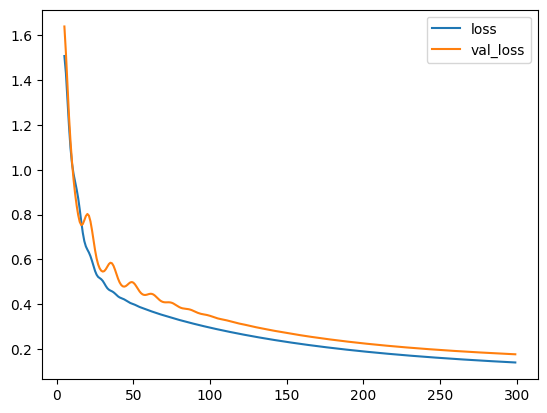

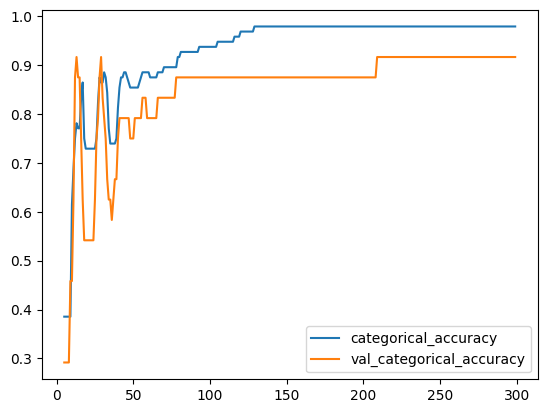

In [13]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

# <u>Evaluating our model:</u>

In [14]:
results = model.evaluate(X_test, y_test, batch_size=32)

1/1 [==============================] - 0s 9ms/step - loss: 0.1412 - categorical_accuracy: 1.0000


In [15]:
y_pred = model.predict(X_test)
y_pred
y_test_classified = np.argmax(y_test.values.tolist(), axis=1)
y_pred_classified = np.argmax(y_pred, axis=1)

1/1 [==============================] - 0s 29ms/step


### Precision, recall of our model:

In [24]:
display(pd.DataFrame.from_dict(
    classification_report(
        y_test_classified,
        y_pred_classified,
        output_dict=True)).T)

,precision,recall,f1-score,support
0,1.0,1.0,1.0,11.0
1,1.0,1.0,1.0,13.0
2,1.0,1.0,1.0,6.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,30.0
weighted avg,1.0,1.0,1.0,30.0


**`RECALL: Is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.`**

**`PRECISION: Is a metric that quantifies the number of correct positive predictions made.`**


#### <u>Comparsion:</u>
**`Unlike precision that only comments on the correct positive predictions out of all positive predictions, recall provides an indication of missed positive predictions.`**

</br>

### Confusion matrix:

In [17]:
matrix = confusion_matrix(y_test_classified, y_pred_classified)
col_names = row_names = labels
better_conf_matrix = pd.DataFrame(matrix, columns=col_names, index=row_names)
better_conf_matrix

,Iris-setosa,Iris-versicolor,Iris-virginica
Iris-setosa,11,0,0
Iris-versicolor,0,13,0
Iris-virginica,0,0,6


**`All predictions were correct.`**

</br>

In [18]:
'''
We create a function of our model to use it in a Keras Classifier
wrapper so we evaluate it with other metrics:
1. Cross-Validation
2. Roc_auc_score
'''

def create_model_for_classifier():
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(units=3, input_shape=(4, ),
                                    activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.04),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return (model)

In [19]:
# Wrap Keras model so it can be used by scikit-learn
model_new = KerasClassifier(model=create_model_for_classifier,
                            epochs=200, batch_size=128)

# evaluate using 10-fold cross validation
results = cross_val_score(model_new, my_feature, my_label,
                          cv=10, scoring='accuracy')

Epoch 1/200
1/1 [==============================] - 0s 251ms/step - loss: 2.4180 - categorical_accuracy: 0.3241
Epoch 2/200
1/1 [==============================] - 0s 2ms/step - loss: 2.2122 - categorical_accuracy: 0.1852
Epoch 3/200
1/1 [==============================] - 0s 1ms/step - loss: 1.9365 - categorical_accuracy: 0.1667
Epoch 4/200
1/1 [==============================] - 0s 1ms/step - loss: 1.6523 - categorical_accuracy: 0.1389
Epoch 5/200
1/1 [==============================] - 0s 1ms/step - loss: 1.3918 - categorical_accuracy: 0.2685
Epoch 6/200
1/1 [==============================] - 0s 1ms/step - loss: 1.1748 - categorical_accuracy: 0.3148
Epoch 7/200
1/1 [==============================] - 0s 1ms/step - loss: 1.0263 - categorical_accuracy: 0.3519
Epoch 8/200
1/1 [==============================] - 0s 1ms/step - loss: 0.9792 - categorical_accuracy: 0.4907
Epoch 9/200
1/1 [==============================] - 0s 1ms/step - loss: 1.0137 - categorical_accuracy: 0.5556
Epoch 10/200
1/1 

1/1 [==============================] - 0s 1ms/step - loss: 0.3133 - categorical_accuracy: 0.9537
Epoch 76/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3113 - categorical_accuracy: 0.9537
Epoch 77/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3094 - categorical_accuracy: 0.9537
Epoch 78/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3074 - categorical_accuracy: 0.9537
Epoch 79/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3055 - categorical_accuracy: 0.9537
Epoch 80/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3036 - categorical_accuracy: 0.9537
Epoch 81/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3018 - categorical_accuracy: 0.9630
Epoch 82/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2999 - categorical_accuracy: 0.9630
Epoch 83/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2981 - categorical_accuracy: 0.9630
Epoch 84/200
1/1 [=====

1/1 [==============================] - 0s 922us/step - loss: 0.2114 - categorical_accuracy: 0.9815
Epoch 149/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2104 - categorical_accuracy: 0.9815
Epoch 150/200
1/1 [==============================] - 0s 982us/step - loss: 0.2095 - categorical_accuracy: 0.9815
Epoch 151/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2085 - categorical_accuracy: 0.9815
Epoch 152/200
1/1 [==============================] - 0s 957us/step - loss: 0.2076 - categorical_accuracy: 0.9815
Epoch 153/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2067 - categorical_accuracy: 0.9815
Epoch 154/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2057 - categorical_accuracy: 0.9815
Epoch 155/200
1/1 [==============================] - 0s 918us/step - loss: 0.2048 - categorical_accuracy: 0.9815
Epoch 156/200
1/1 [==============================] - 0s 990us/step - loss: 0.2039 - categorical_accuracy: 0.9815
Epoch

1/1 [==============================] - 0s 1ms/step - loss: 0.7155 - categorical_accuracy: 0.6481
Epoch 22/200
1/1 [==============================] - 0s 1ms/step - loss: 0.6828 - categorical_accuracy: 0.6852
Epoch 23/200
1/1 [==============================] - 0s 1ms/step - loss: 0.6506 - categorical_accuracy: 0.7037
Epoch 24/200
1/1 [==============================] - 0s 1ms/step - loss: 0.6229 - categorical_accuracy: 0.7315
Epoch 25/200
1/1 [==============================] - 0s 1ms/step - loss: 0.6014 - categorical_accuracy: 0.7222
Epoch 26/200
1/1 [==============================] - 0s 1ms/step - loss: 0.5859 - categorical_accuracy: 0.7407
Epoch 27/200
1/1 [==============================] - 0s 1ms/step - loss: 0.5752 - categorical_accuracy: 0.7593
Epoch 28/200
1/1 [==============================] - 0s 2ms/step - loss: 0.5677 - categorical_accuracy: 0.7870
Epoch 29/200
1/1 [==============================] - 0s 1ms/step - loss: 0.5615 - categorical_accuracy: 0.7778
Epoch 30/200
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.3147 - categorical_accuracy: 0.9352
Epoch 96/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3129 - categorical_accuracy: 0.9352
Epoch 97/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3112 - categorical_accuracy: 0.9352
Epoch 98/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3094 - categorical_accuracy: 0.9352
Epoch 99/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3077 - categorical_accuracy: 0.9352
Epoch 100/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3060 - categorical_accuracy: 0.9352
Epoch 101/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3043 - categorical_accuracy: 0.9352
Epoch 102/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3027 - categorical_accuracy: 0.9352
Epoch 103/200
1/1 [==============================] - 0s 947us/step - loss: 0.3010 - categorical_accuracy: 0.9352
Epoch 104/200
1/1

1/1 [==============================] - 0s 1ms/step - loss: 0.2217 - categorical_accuracy: 0.9444
Epoch 169/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2208 - categorical_accuracy: 0.9444
Epoch 170/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2199 - categorical_accuracy: 0.9444
Epoch 171/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2191 - categorical_accuracy: 0.9444
Epoch 172/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2182 - categorical_accuracy: 0.9444
Epoch 173/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2173 - categorical_accuracy: 0.9444
Epoch 174/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2165 - categorical_accuracy: 0.9444
Epoch 175/200
1/1 [==============================] - 0s 919us/step - loss: 0.2157 - categorical_accuracy: 0.9444
Epoch 176/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2148 - categorical_accuracy: 0.9444
Epoch 177/200

1/1 [==============================] - 0s 956us/step - loss: 0.5274 - categorical_accuracy: 0.8056
Epoch 42/200
1/1 [==============================] - 0s 1ms/step - loss: 0.5369 - categorical_accuracy: 0.8333
Epoch 43/200
1/1 [==============================] - 0s 967us/step - loss: 0.5501 - categorical_accuracy: 0.7778
Epoch 44/200
1/1 [==============================] - 0s 876us/step - loss: 0.5591 - categorical_accuracy: 0.7407
Epoch 45/200
1/1 [==============================] - 0s 953us/step - loss: 0.5585 - categorical_accuracy: 0.7407
Epoch 46/200
1/1 [==============================] - 0s 1ms/step - loss: 0.5478 - categorical_accuracy: 0.7500
Epoch 47/200
1/1 [==============================] - 0s 991us/step - loss: 0.5304 - categorical_accuracy: 0.7870
Epoch 48/200
1/1 [==============================] - 0s 937us/step - loss: 0.5119 - categorical_accuracy: 0.8426
Epoch 49/200
1/1 [==============================] - 0s 1ms/step - loss: 0.4974 - categorical_accuracy: 0.8519
Epoch 50/20

1/1 [==============================] - 0s 1ms/step - loss: 0.3490 - categorical_accuracy: 0.9444
Epoch 116/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3475 - categorical_accuracy: 0.9444
Epoch 117/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3459 - categorical_accuracy: 0.9444
Epoch 118/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3444 - categorical_accuracy: 0.9444
Epoch 119/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3429 - categorical_accuracy: 0.9444
Epoch 120/200
1/1 [==============================] - 0s 987us/step - loss: 0.3414 - categorical_accuracy: 0.9444
Epoch 121/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3399 - categorical_accuracy: 0.9444
Epoch 122/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3384 - categorical_accuracy: 0.9444
Epoch 123/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3369 - categorical_accuracy: 0.9444
Epoch 124/200

1/1 [==============================] - 0s 1ms/step - loss: 0.2590 - categorical_accuracy: 0.9630
Epoch 189/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2581 - categorical_accuracy: 0.9630
Epoch 190/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2571 - categorical_accuracy: 0.9630
Epoch 191/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2562 - categorical_accuracy: 0.9630
Epoch 192/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2552 - categorical_accuracy: 0.9630
Epoch 193/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2543 - categorical_accuracy: 0.9630
Epoch 194/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2534 - categorical_accuracy: 0.9630
Epoch 195/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2525 - categorical_accuracy: 0.9630
Epoch 196/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2516 - categorical_accuracy: 0.9630
Epoch 197/200
1

1/1 [==============================] - 0s 2ms/step - loss: 0.3625 - categorical_accuracy: 0.9444
Epoch 63/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3601 - categorical_accuracy: 0.9444
Epoch 64/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3576 - categorical_accuracy: 0.9444
Epoch 65/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3551 - categorical_accuracy: 0.9444
Epoch 66/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3526 - categorical_accuracy: 0.9444
Epoch 67/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3500 - categorical_accuracy: 0.9444
Epoch 68/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3475 - categorical_accuracy: 0.9444
Epoch 69/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3452 - categorical_accuracy: 0.9444
Epoch 70/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3429 - categorical_accuracy: 0.9444
Epoch 71/200
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.2350 - categorical_accuracy: 0.9722
Epoch 137/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2339 - categorical_accuracy: 0.9722
Epoch 138/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2328 - categorical_accuracy: 0.9722
Epoch 139/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2317 - categorical_accuracy: 0.9722
Epoch 140/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2306 - categorical_accuracy: 0.9722
Epoch 141/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2295 - categorical_accuracy: 0.9722
Epoch 142/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2284 - categorical_accuracy: 0.9722
Epoch 143/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2274 - categorical_accuracy: 0.9722
Epoch 144/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2263 - categorical_accuracy: 0.9722
Epoch 145/200
1

1/1 [==============================] - 0s 1ms/step - loss: 1.7192 - categorical_accuracy: 0.6759
Epoch 4/200
1/1 [==============================] - 0s 1ms/step - loss: 1.4310 - categorical_accuracy: 0.6759
Epoch 5/200
1/1 [==============================] - 0s 1ms/step - loss: 1.1517 - categorical_accuracy: 0.6481
Epoch 6/200
1/1 [==============================] - 0s 1ms/step - loss: 0.9287 - categorical_accuracy: 0.6759
Epoch 7/200
1/1 [==============================] - 0s 1ms/step - loss: 0.8414 - categorical_accuracy: 0.8148
Epoch 8/200
1/1 [==============================] - 0s 1ms/step - loss: 0.9065 - categorical_accuracy: 0.4352
Epoch 9/200
1/1 [==============================] - 0s 1ms/step - loss: 1.0068 - categorical_accuracy: 0.3241
Epoch 10/200
1/1 [==============================] - 0s 1ms/step - loss: 1.0399 - categorical_accuracy: 0.3241
Epoch 11/200
1/1 [==============================] - 0s 1ms/step - loss: 0.9935 - categorical_accuracy: 0.3241
Epoch 12/200
1/1 [===========

1/1 [==============================] - 0s 1ms/step - loss: 0.3451 - categorical_accuracy: 0.9352
Epoch 78/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3433 - categorical_accuracy: 0.9352
Epoch 79/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3414 - categorical_accuracy: 0.9352
Epoch 80/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3395 - categorical_accuracy: 0.9352
Epoch 81/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3375 - categorical_accuracy: 0.9352
Epoch 82/200
1/1 [==============================] - 0s 847us/step - loss: 0.3356 - categorical_accuracy: 0.9537
Epoch 83/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3338 - categorical_accuracy: 0.9537
Epoch 84/200
1/1 [==============================] - 0s 991us/step - loss: 0.3320 - categorical_accuracy: 0.9630
Epoch 85/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3302 - categorical_accuracy: 0.9444
Epoch 86/200
1/1 [=

1/1 [==============================] - 0s 1ms/step - loss: 0.2419 - categorical_accuracy: 0.9630
Epoch 151/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2408 - categorical_accuracy: 0.9722
Epoch 152/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2398 - categorical_accuracy: 0.9722
Epoch 153/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2388 - categorical_accuracy: 0.9722
Epoch 154/200
1/1 [==============================] - 0s 978us/step - loss: 0.2378 - categorical_accuracy: 0.9722
Epoch 155/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2369 - categorical_accuracy: 0.9722
Epoch 156/200
1/1 [==============================] - 0s 893us/step - loss: 0.2359 - categorical_accuracy: 0.9722
Epoch 157/200
1/1 [==============================] - 0s 853us/step - loss: 0.2349 - categorical_accuracy: 0.9722
Epoch 158/200
1/1 [==============================] - 0s 910us/step - loss: 0.2340 - categorical_accuracy: 0.9722
Epoch 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 125ms/step - loss: 4.1854 - categorical_accuracy: 0.3056
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 3.3872 - categorical_accuracy: 0.3056
Epoch 3/200
1/1 [==============================] - 0s 1ms/step - loss: 2.6473 - categorical_accuracy: 0.3056
Epoch 4/200
1/1 [==============================] - 0s 904us/step - loss: 2.0447 - categorical_accuracy: 0.3056
Epoch 5/200
1/1 [==============================] - 0s 984us/step - loss: 1.6995 - categorical_accuracy: 0.3519
Epoch 6/200
1/1 [==============================] - 0s 956us/step - loss: 1.6126 - categorical_accuracy: 0.3889
Epoch 7/200
1/1 [==============================] - 0s 985us/step - loss: 1.5997 - categorical_accuracy: 0.3889
Epoch 8/200
1/1 [==============================] - 0s 1ms/step - loss: 1.5480 - categorical_accuracy: 0.3889
Epoch 9/200
1/1 [==============================] - 0s 2ms/step - loss: 1.4426 - categorical_accuracy: 0.3889
Epoch 10/200
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.4050 - categorical_accuracy: 0.8889
Epoch 76/200
1/1 [==============================] - 0s 1ms/step - loss: 0.4029 - categorical_accuracy: 0.8889
Epoch 77/200
1/1 [==============================] - 0s 1ms/step - loss: 0.4008 - categorical_accuracy: 0.8889
Epoch 78/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3988 - categorical_accuracy: 0.8889
Epoch 79/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3969 - categorical_accuracy: 0.8889
Epoch 80/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3950 - categorical_accuracy: 0.8889
Epoch 81/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3931 - categorical_accuracy: 0.8889
Epoch 82/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3912 - categorical_accuracy: 0.8796
Epoch 83/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3893 - categorical_accuracy: 0.8889
Epoch 84/200
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 0.2960 - categorical_accuracy: 0.9444
Epoch 150/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2949 - categorical_accuracy: 0.9444
Epoch 151/200
1/1 [==============================] - 0s 887us/step - loss: 0.2939 - categorical_accuracy: 0.9537
Epoch 152/200
1/1 [==============================] - 0s 948us/step - loss: 0.2928 - categorical_accuracy: 0.9537
Epoch 153/200
1/1 [==============================] - 0s 956us/step - loss: 0.2917 - categorical_accuracy: 0.9537
Epoch 154/200
1/1 [==============================] - 0s 931us/step - loss: 0.2906 - categorical_accuracy: 0.9537
Epoch 155/200
1/1 [==============================] - 0s 927us/step - loss: 0.2896 - categorical_accuracy: 0.9537
Epoch 156/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2885 - categorical_accuracy: 0.9537
Epoch 157/200
1/1 [==============================] - 0s 891us/step - loss: 0.2875 - categorical_accuracy: 0.9537
Epo

1/1 [==============================] - 0s 2ms/step - loss: 0.7761 - categorical_accuracy: 0.6111
Epoch 23/200
1/1 [==============================] - 0s 1ms/step - loss: 0.7846 - categorical_accuracy: 0.6389
Epoch 24/200
1/1 [==============================] - 0s 1ms/step - loss: 0.7926 - categorical_accuracy: 0.6481
Epoch 25/200
1/1 [==============================] - 0s 1ms/step - loss: 0.7889 - categorical_accuracy: 0.6389
Epoch 26/200
1/1 [==============================] - 0s 1ms/step - loss: 0.7687 - categorical_accuracy: 0.6481
Epoch 27/200
1/1 [==============================] - 0s 1ms/step - loss: 0.7338 - categorical_accuracy: 0.6481
Epoch 28/200
1/1 [==============================] - 0s 1ms/step - loss: 0.6911 - categorical_accuracy: 0.6481
Epoch 29/200
1/1 [==============================] - 0s 940us/step - loss: 0.6498 - categorical_accuracy: 0.6574
Epoch 30/200
1/1 [==============================] - 0s 937us/step - loss: 0.6184 - categorical_accuracy: 0.7500
Epoch 31/200
1/1 [=

1/1 [==============================] - 0s 2ms/step - loss: 0.3592 - categorical_accuracy: 0.8981
Epoch 97/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3577 - categorical_accuracy: 0.8889
Epoch 98/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3561 - categorical_accuracy: 0.8981
Epoch 99/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3546 - categorical_accuracy: 0.8981
Epoch 100/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3530 - categorical_accuracy: 0.8981
Epoch 101/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3515 - categorical_accuracy: 0.8981
Epoch 102/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3500 - categorical_accuracy: 0.8981
Epoch 103/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3485 - categorical_accuracy: 0.8981
Epoch 104/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3470 - categorical_accuracy: 0.9074
Epoch 105/200
1/1 

1/1 [==============================] - 0s 1ms/step - loss: 0.2709 - categorical_accuracy: 0.9352
Epoch 170/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2700 - categorical_accuracy: 0.9352
Epoch 171/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2691 - categorical_accuracy: 0.9352
Epoch 172/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2681 - categorical_accuracy: 0.9352
Epoch 173/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2672 - categorical_accuracy: 0.9352
Epoch 174/200
1/1 [==============================] - 0s 981us/step - loss: 0.2663 - categorical_accuracy: 0.9352
Epoch 175/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2654 - categorical_accuracy: 0.9352
Epoch 176/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2645 - categorical_accuracy: 0.9352
Epoch 177/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2636 - categorical_accuracy: 0.9352
Epoch 178/200

1/1 [==============================] - 0s 1ms/step - loss: 0.4818 - categorical_accuracy: 0.7500
Epoch 43/200
1/1 [==============================] - 0s 2ms/step - loss: 0.4784 - categorical_accuracy: 0.7315
Epoch 44/200
1/1 [==============================] - 0s 1ms/step - loss: 0.4752 - categorical_accuracy: 0.7315
Epoch 45/200
1/1 [==============================] - 0s 1ms/step - loss: 0.4702 - categorical_accuracy: 0.7315
Epoch 46/200
1/1 [==============================] - 0s 2ms/step - loss: 0.4628 - categorical_accuracy: 0.7315
Epoch 47/200
1/1 [==============================] - 0s 1ms/step - loss: 0.4537 - categorical_accuracy: 0.7315
Epoch 48/200
1/1 [==============================] - 0s 1ms/step - loss: 0.4446 - categorical_accuracy: 0.7500
Epoch 49/200
1/1 [==============================] - 0s 1ms/step - loss: 0.4372 - categorical_accuracy: 0.7870
Epoch 50/200
1/1 [==============================] - 0s 1ms/step - loss: 0.4325 - categorical_accuracy: 0.8519
Epoch 51/200
1/1 [=====

1/1 [==============================] - 0s 908us/step - loss: 0.2990 - categorical_accuracy: 0.9630
Epoch 117/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2977 - categorical_accuracy: 0.9630
Epoch 118/200
1/1 [==============================] - 0s 886us/step - loss: 0.2963 - categorical_accuracy: 0.9630
Epoch 119/200
1/1 [==============================] - 0s 860us/step - loss: 0.2950 - categorical_accuracy: 0.9630
Epoch 120/200
1/1 [==============================] - 0s 912us/step - loss: 0.2937 - categorical_accuracy: 0.9630
Epoch 121/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2924 - categorical_accuracy: 0.9630
Epoch 122/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2911 - categorical_accuracy: 0.9630
Epoch 123/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2899 - categorical_accuracy: 0.9630
Epoch 124/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2886 - categorical_accuracy: 0.9630
Epoch 1

1/1 [==============================] - 0s 1ms/step - loss: 0.2228 - categorical_accuracy: 0.9722
Epoch 190/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2220 - categorical_accuracy: 0.9722
Epoch 191/200
1/1 [==============================] - 0s 969us/step - loss: 0.2212 - categorical_accuracy: 0.9722
Epoch 192/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2204 - categorical_accuracy: 0.9722
Epoch 193/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2196 - categorical_accuracy: 0.9722
Epoch 194/200
1/1 [==============================] - 0s 815us/step - loss: 0.2188 - categorical_accuracy: 0.9722
Epoch 195/200
1/1 [==============================] - 0s 957us/step - loss: 0.2181 - categorical_accuracy: 0.9722
Epoch 196/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2173 - categorical_accuracy: 0.9722
Epoch 197/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2165 - categorical_accuracy: 0.9722
Epoch 198

1/1 [==============================] - 0s 990us/step - loss: 0.4591 - categorical_accuracy: 0.8611
Epoch 63/200
1/1 [==============================] - 0s 915us/step - loss: 0.4566 - categorical_accuracy: 0.8611
Epoch 64/200
1/1 [==============================] - 0s 944us/step - loss: 0.4535 - categorical_accuracy: 0.8611
Epoch 65/200
1/1 [==============================] - 0s 1ms/step - loss: 0.4499 - categorical_accuracy: 0.8611
Epoch 66/200
1/1 [==============================] - 0s 910us/step - loss: 0.4463 - categorical_accuracy: 0.8426
Epoch 67/200
1/1 [==============================] - 0s 1ms/step - loss: 0.4431 - categorical_accuracy: 0.8426
Epoch 68/200
1/1 [==============================] - 0s 965us/step - loss: 0.4404 - categorical_accuracy: 0.8333
Epoch 69/200
1/1 [==============================] - 0s 915us/step - loss: 0.4381 - categorical_accuracy: 0.8333
Epoch 70/200
1/1 [==============================] - 0s 1ms/step - loss: 0.4360 - categorical_accuracy: 0.8148
Epoch 71/20

1/1 [==============================] - 0s 1ms/step - loss: 0.3237 - categorical_accuracy: 0.9259
Epoch 136/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3224 - categorical_accuracy: 0.9259
Epoch 137/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3211 - categorical_accuracy: 0.9352
Epoch 138/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3198 - categorical_accuracy: 0.9352
Epoch 139/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3186 - categorical_accuracy: 0.9352
Epoch 140/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3173 - categorical_accuracy: 0.9352
Epoch 141/200
1/1 [==============================] - 0s 910us/step - loss: 0.3161 - categorical_accuracy: 0.9352
Epoch 142/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3148 - categorical_accuracy: 0.9352
Epoch 143/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3136 - categorical_accuracy: 0.9352
Epoch 144/200

In [20]:
print(f'Mean accuracy between all folds is: {results.mean()}')

Mean accuracy between all folds is: 0.9583333333333334


In [21]:
model_new.fit(my_feature, my_label)

Epoch 1/200
1/1 [==============================] - 0s 122ms/step - loss: 3.0822 - categorical_accuracy: 0.3083
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 2.3076 - categorical_accuracy: 0.3083
Epoch 3/200
1/1 [==============================] - 0s 990us/step - loss: 1.6225 - categorical_accuracy: 0.3083
Epoch 4/200
1/1 [==============================] - 0s 939us/step - loss: 1.1337 - categorical_accuracy: 0.3667
Epoch 5/200
1/1 [==============================] - 0s 1ms/step - loss: 0.8917 - categorical_accuracy: 0.5667
Epoch 6/200
1/1 [==============================] - 0s 964us/step - loss: 0.8390 - categorical_accuracy: 0.6667
Epoch 7/200
1/1 [==============================] - 0s 970us/step - loss: 0.8961 - categorical_accuracy: 0.6917
Epoch 8/200
1/1 [==============================] - 0s 1ms/step - loss: 0.9943 - categorical_accuracy: 0.6833
Epoch 9/200
1/1 [==============================] - 0s 888us/step - loss: 1.0801 - categorical_accuracy: 0.6833
Epoch 1

1/1 [==============================] - 0s 2ms/step - loss: 0.3470 - categorical_accuracy: 0.9250
Epoch 76/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3455 - categorical_accuracy: 0.9250
Epoch 77/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3440 - categorical_accuracy: 0.9250
Epoch 78/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3423 - categorical_accuracy: 0.9250
Epoch 79/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3405 - categorical_accuracy: 0.9250
Epoch 80/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3387 - categorical_accuracy: 0.9333
Epoch 81/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3371 - categorical_accuracy: 0.9333
Epoch 82/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3355 - categorical_accuracy: 0.9250
Epoch 83/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3340 - categorical_accuracy: 0.9250
Epoch 84/200
1/1 [=====

1/1 [==============================] - 0s 877us/step - loss: 0.2540 - categorical_accuracy: 0.9333
Epoch 149/200
1/1 [==============================] - 0s 941us/step - loss: 0.2530 - categorical_accuracy: 0.9333
Epoch 150/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2520 - categorical_accuracy: 0.9333
Epoch 151/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2511 - categorical_accuracy: 0.9333
Epoch 152/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2501 - categorical_accuracy: 0.9333
Epoch 153/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2492 - categorical_accuracy: 0.9333
Epoch 154/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2482 - categorical_accuracy: 0.9333
Epoch 155/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2473 - categorical_accuracy: 0.9333
Epoch 156/200
1/1 [==============================] - 0s 1ms/step - loss: 0.2464 - categorical_accuracy: 0.9333
Epoch 157/2

KerasClassifier(
	model=<function create_model_for_classifier at 0x7f4af4333d90>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=128
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=200
	class_weight=None
)

In [22]:
y_prob = model_new.predict_proba(X_test)

1/1 [==============================] - 0s 17ms/step


In [23]:
score_roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovo')

print(f' The ROC_AUC_SCORE of our model is: {score_roc_auc }')

 The ROC_AUC_SCORE of our model is: 1.0


</br>

### Custom examples to test:

In [31]:
# setosa, versicolor, virginica
custom_test = np.array([[4.5, 3, 1.5, 0.2],
                        [6, 3, 4, 1.5],
                        [7, 3.5, 6, 1.9]])
y_custom_pred = model.predict(custom_test)
print(np.argmax(y_custom_pred, axis=1))

1/1 [==============================] - 0s 15ms/step
[0 1 2]
